In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/weaviate/postings.csv.zip" -d "/content/drive/MyDrive/weaviate"

Archive:  /content/drive/MyDrive/weaviate/postings.csv.zip
replace /content/drive/MyDrive/weaviate/postings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# importing required packages
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
# Download required NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import string

In [ ]:
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=6dc40d81cb7cd77bb2ff79dd62de1b0c7634cf0d4cffc1e754bb855d85e8970a
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


In [ ]:
import swifter

In [ ]:
#change directory
os.chdir("/content/drive/MyDrive/weaviate/")

### Data Exploration Stage

In [ ]:
# Load the dataset
job_data = pd.read_csv('postings.csv')

In [ ]:
# Data Analysis to check for missing data
job_data.head()

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,1.715990e+12,NaN,NaN,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,1.715450e+12,NaN,NaN,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,1.715870e+12,NaN,NaN,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,1.715488e+12,NaN,NaN,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,1.716044e+12,NaN,NaN,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY


In [ ]:
# Check for number of records
job_data.shape

(123849, 28)

In [ ]:
#check for missing data
job_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123849 entries, 0 to 123848
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   job_id                      123849 non-null  int64  
 1   company_name                122130 non-null  object 
 2   title                       123849 non-null  object 
 3   description                 123842 non-null  object 
 4   max_salary                  29793 non-null   float64
 5   pay_period                  36073 non-null   object 
 6   location                    123849 non-null  object 
 7   company_id                  122132 non-null  float64
 8   views                       122160 non-null  float64
 9   med_salary                  6280 non-null    float64
 10  min_salary                  29793 non-null   float64
 11  formatted_work_type         123849 non-null  object 
 12  applies                     23320 non-null   float64
 13  original_liste

In [ ]:
# Extract only the relevant columns
job_data2 = job_data.loc[:, ['job_id', 'title', 'description']]

In [ ]:
job_data2.shape

(123849, 3)

In [ ]:
# Drop rows with None or NaN in the 'text' column
job_data2 = job_data2.dropna()

In [ ]:
job_data2.shape

(123842, 3)

In [ ]:
# Combine job title and job description into a single text column
job_data2['text'] = job_data2['title'] + ' ' + job_data2['description']

In [ ]:
job_data2.head()

,job_id,title,description,text
0,921716,Marketing Coordinator,Job descriptionA leading real estate firm in N...,Marketing Coordinator Job descriptionA leading...
1,1829192,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",Mental Health Therapist/Counselor At Aspen The...
2,10998357,Assitant Restaurant Manager,The National Exemplar is accepting application...,Assitant Restaurant Manager The National Exemp...
3,23221523,Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,Senior Elder Law / Trusts and Estates Associat...
4,35982263,Service Technician,Looking for HVAC service tech with experience ...,Service Technician Looking for HVAC service t...


In [ ]:
job_data2.iloc[0,3]

'Marketing Coordinator Job descriptionA leading real estate firm in New Jersey is seeking an administrative Marketing Coordinator with some experience in graphic design. You will be working closely with our fun, kind, ambitious members of the sales team and our dynamic executive team on a daily basis. This is an opportunity to be part of a fast-growing, highly respected real estate brokerage with a reputation for exceptional marketing and extraordinary culture of cooperation and inclusion.Who you are:You must be a well-organized, creative, proactive, positive, and most importantly, kind-hearted person. Please, be responsible, respectful, and cool-under-pressure. Please, be proficient in Adobe Creative Cloud (Indesign, Illustrator, Photoshop) and Microsoft Office Suite. Above all, have fantastic taste and be a good-hearted, fun-loving person who loves working with people and is eager to learn.Role:Our office is a fast-paced environment. You’ll work directly with a Marketing team and com

### Data Preprocessing Stage

In [ ]:
 # Function definition to preprocess text
def preprocess_text(text):
    # Define the regex pattern to remove camel casing
    # pattern = r'(?<!^)(?=[A-Z])'
    pattern = r"(job description)|(Job description)|(Job Description)|((1-\d{3}-\d{3}-\d{4})|(\(\d{3}\) \d{3}-\d{4})|(\d{3}-\d{3}-\d{4}))$"

    # patern2 = r"[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+"
    pattern2 = r"[A-Za-z0-9]*@[A-Za-z]*\.?[A-Za-z0-9]*"
    pattern3 = r'\bAI/ML\b'
    pattern4 = r'\bAI\b'
    pattern5 = r'\bML\b'
    pattern6 = r'\bNLP\b'



    # Apply the regex replacement to the 'text'
    text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    text = re.sub(pattern2, '', text, flags=re.IGNORECASE) # remove email address
    text = re.sub(pattern3, 'artificial intelligence/Machine learning', text, flags=re.IGNORECASE) # replace AI/ML with artificial intelligence/Machine learning
    text = re.sub(pattern4, 'artificial intelligence', text, flags=re.IGNORECASE) # replace AI with artificial intelligence
    text = re.sub(pattern5, 'Machine learning', text, flags=re.IGNORECASE) # replace AI with Machine learning
    text = re.sub(pattern6, 'natural language processing', text, flags=re.IGNORECASE) # replace AI with Machine learning
    text = re.sub(r'(\b\w+)/(\w+\b)', r'\1 / \2', text) # add spaces around the slash for patterns like "AI/ML", "AL/ML", etc.

    # Convert to lowercase
    text = text.lower()

    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Stem words
    # stemmer = PorterStemmer()
    # tokens = [stemmer.stem(word) for word in tokens]

    # Join tokens back into a single string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

# Apply preprocessing to the text column
# job_data2['preprocessed_text'] = job_data2['text'].apply(preprocess_text)

# Apply preprocessing to the text column
job_data2['preprocessed_text'] = job_data2['text'].swifter.apply(preprocess_text)


Pandas Apply:   0%|          | 0/123842 [00:00<?, ?it/s]

In [ ]:
job_data2.head()

,job_id,title,description,text,preprocessed_text
0,921716,Marketing Coordinator,Job descriptionA leading real estate firm in N...,Marketing Coordinator Job descriptionA leading...,marketing coordinator leading real estate firm...
1,1829192,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",Mental Health Therapist/Counselor At Aspen The...,mental health therapistcounselor aspen therapy...
2,10998357,Assitant Restaurant Manager,The National Exemplar is accepting application...,Assitant Restaurant Manager The National Exemp...,assitant restaurant manager national exemplar ...
3,23221523,Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,Senior Elder Law / Trusts and Estates Associat...,senior elder law trusts estates associate atto...
4,35982263,Service Technician,Looking for HVAC service tech with experience ...,Service Technician Looking for HVAC service t...,service technician looking hvac service tech e...


In [ ]:
ml_ai_keywords = ["machine learning", "deep learning", "natural language processing", "computer vision", "artificial intelligence", "neural network", "reinforcement learning"]


In [ ]:
#check if partial string 'Machine learning' exists in conference column
# job_data2[job_data2['title'].str.contains('Robotics')]['description'].str.contains('computer vision')
print(job_data2.loc[job_data2['job_id'] == 4968, 'description'])

Series([], Name: description, dtype: object)


In [ ]:
job_data2.iloc[2,3]

'Assitant Restaurant Manager The National Exemplar is accepting applications for an Assistant Restaurant Manager.\nWe offer highly competitive wages, healthcare, paid time off, complimentary dining privileges and bonus opportunities. \nWe are a serious, professional, long-standing neighborhood restaurant with over 41 years of service. If you are looking for a long-term fit with a best in class organization then you should apply now. \nPlease send a resumes to pardom@nationalexemplar.com. o'

In [ ]:
job_data2.iloc[2,4]

'assitant restaurant manager national exemplar accepting applications assistant restaurant manager offer highly competitive wages healthcare paid time complimentary dining privileges bonus opportunities serious professional longstanding neighborhood restaurant years service looking longterm fit best class organization apply please send resumes'

### Feature Extraction

In [ ]:
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the preprocessed text data
X = vectorizer.fit_transform(job_data2['preprocessed_text'])

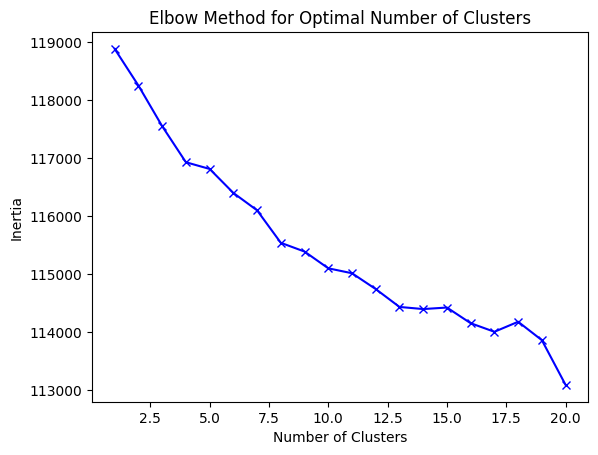

In [ ]:
# Determine the optimal number of clusters using the elbow method
inertia = []
k_values = range(1, 21)
for k in k_values:
    mbk = MiniBatchKMeans(n_clusters=k, batch_size=1024, random_state=42)
    mbk.fit(X)
    inertia.append(mbk.inertia_)

plt.plot(k_values, inertia, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

### Clustering using K-Means

In [ ]:

# Determine the optimal number of clusters using the elbow method
inertia = []
for k in range(1, 15 ):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 21), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
# Based on the elbow plot, choose the optimal number of clusters
n_clusters = 5

# Perform K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# Add cluster labels to the original dataset
job_data2['cluster'] = labels

In [ ]:
# Based on the elbow plot, choose the optimal number of clusters
n_clusters = 17  # Optimal cluster based on the elbow plot

# Perform MiniBatchKMeans clustering with the chosen parameters
mbk = MiniBatchKMeans(n_clusters=n_clusters, batch_size=1024, random_state=42)
labels = mbk.fit_predict(X)

# Add cluster labels to the original dataset
job_data2['cluster'] = labels


In [ ]:
job_data2.head()

,job_id,title,description,text,preprocessed_text,cluster
0,921716,Marketing Coordinator,Job descriptionA leading real estate firm in N...,Marketing Coordinator Job descriptionA leading...,marketing coordinator leading real estate firm...,12
1,1829192,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",Mental Health Therapist/Counselor At Aspen The...,mental health therapist counselor aspen therap...,15
2,10998357,Assitant Restaurant Manager,The National Exemplar is accepting application...,Assitant Restaurant Manager The National Exemp...,assitant restaurant manager national exemplar ...,3
3,23221523,Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,Senior Elder Law / Trusts and Estates Associat...,senior elder law trusts estates associate atto...,3
4,35982263,Service Technician,Looking for HVAC service tech with experience ...,Service Technician Looking for HVAC service t...,service technician looking hvac service tech e...,4


### Cluster Analysis

In [ ]:
# Analyze the clusters to identify those related to ML/AI
# for cluster_id in range(n_clusters):
#     cluster_jobs = job_data2[job_data2['cluster'] == cluster_id]
#     print(f'Cluster {cluster_id}:')
#     print(cluster_jobs['title'].sample(5))
#     print('\n')

for cluster_id in range(n_clusters):
    cluster_jobs = job_data2[job_data2['cluster'] == cluster_id]
    print(f'Cluster {cluster_id}:')

    # Get the number of job titles in the cluster
    num_jobs = len(cluster_jobs['title'])

    # Sample up to 5 job titles, or print all if fewer than 5
    if num_jobs <= 25:
        print(cluster_jobs['title'].tolist())
    else:
        print(cluster_jobs['title'].sample(25))

    print('\n')


Cluster 0:
108506    Part Time Retail Merchandiser - Allen Park MI ...
88488     Part Time Retail Merchandiser - Columbus OH 43228
87505     Part Time Retail Merchandiser - Casa Grande AZ...
123025      Part Time Retail Merchandiser - Monroe NY 10950
88288     Part Time Retail Merchandiser - Doylestown OH ...
123023    Part Time Retail Merchandiser - Kingston NY 12401
88149     Part Time Retail Merchandiser Floater - Corpus...
123065    Part Time Retail Merchandiser - Columbia TN 38401
122554    Part Time Retail Merchandiser - Capital Height...
31851      Part Time Retail Merchandiser - Glasgow KY 42141
88142      Part Time Retail Merchandiser - Foxboro MA 02035
31614     Part Time Retail Merchandiser - Muskegon MI 49444
31807     Part Time Retail Merchandiser - St. Louis MO 6...
123514    Part Time Retail Merchandiser Floater - Washin...
31776      Part Time Retail Merchandiser - Brandon FL 33511
31687     Part Time Retail Merchandiser - Goodyear AZ 85395
31717     Part Time Retail Me

In [ ]:
# Filter the dataframe to get rows where 'cluster' column is 8
cluster_6 = job_data2[job_data2['cluster'] == 6]

print(f"Job titles in cluster 6:")
for idx, title in enumerate(cluster_6['title'], start=1):
    print(f"{idx}. {title}")


Job titles in cluster 6:
1. Machine Learning Engineer
2. Generative AI Engineer
3. Senior Data Analyst - AI Training (Remote, Contract)
4. Django Engineer
5. AI Training for Nuclear Physics
6. Package Handler - Part Time (Warehouse like)
7. Package Handler (Warehouse like)
8. Package Handler - Part Time (Warehouse like)
9. Package Handler - Part Time (Warehouse like)
10. Package Handler - Part Time (Warehouse like)
11. Package Handler - Part Time (Warehouse like)
12. Package Handler Huntsville Metro Area Locations (Warehouse like)
13. Package Handler - Part Time (Warehouse like)
14. Package Handler - Part & Full Time (Warehouse like)
15. Package Handler - Part Time (Warehouse like)
16. Package Handler - Part Time (Warehouse like)
17. Package Handler - Part Time (Warehouse like)
18. Package Handler - Part Time (Warehouse like)
19. AI Solution Architect
20. Product Manager
21. MLE/AI Engineer Summer Intern
22. Gen AI Enginner
23. Software Engineer Intern
24. Tutor
25. Python Developer
26

In [ ]:
# Visualize the clusters using t-SNE
from sklearn.manifold import TSNE

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, init='random')
X_tsne = tsne.fit_transform(X)

# Plot the clusters
plt.figure(figsize=(10, 8))
for cluster_id in range(n_clusters):
    cluster_jobs = job_data2[job_data2['cluster'] == cluster_id]
    plt.scatter(X_tsne[cluster_jobs.index, 0], X_tsne[cluster_jobs.index, 1], label=f'Cluster {cluster_id}')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

# Convert sparse data to dense
X_dense = X.toarray()

# Apply PCA
pca = PCA(n_components=50)
X_reduced = pca.fit_transform(X_dense)

# Plot the projected data with cluster labels
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of Clusters (PCA Projection)')
plt.show()

In [ ]:
# Assuming 'X' is your feature matrix and 'y' are the labels
cluster_to_visualize = 3  # Specify the cluster label
X_cluster = X[y == cluster_to_visualize]  # Data points in the cluster
X_other = X[y != cluster_to_visualize]  # Other data points

from sklearn.manifold import TSNE

# Combine cluster and other data points
X_combined = np.concatenate((X_cluster, X_other), axis=0)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_projected = tsne.fit_transform(X_combined)

import matplotlib.pyplot as plt

# Separate cluster and other points in the projected space
cluster_points = X_projected[:len(X_cluster)]
other_points = X_projected[len(X_cluster):]

# Plot the cluster and other points
plt.figure(figsize=(10, 8))
plt.scatter(other_points[:, 0], other_points[:, 1], alpha=0.3, label='Other data')
plt.scatter(cluster_points[:, 0], cluster_points[:, 1], alpha=0.8, label=f'Cluster {cluster_to_visualize}')
plt.legend()
plt.title(f'Visualization of Cluster {cluster_to_visualize} using t-SNE')
plt.show()

NameError: name 'X' is not defined